# Notes:
- Any of the analysis in http://web.mit.edu/ceder/publications/prb_76_165435.pdf, I should also be able to perform, including prettier diagrams etc. if wanted, just let me know!
- If there is anything else specifically that you would be interested in (such as stuff to do with charge density (see CrystalMaker files), local potential etc., let me know and I can do analysis regarding that.
- These calculations are _in vacuo_, so no specific solvent effects are included. However, the presence of solvent molecules is not expected to significantly influence the equilibrium (relaxed) structures or thermodynamics, but is expected to influence the (crystal growth) kinetics (i.e. enhancing stabilisation of a particular nanoparticle facet). To do more specific investigation on solvent effects etc. would require a huge number of Molecular Dynamics simulations etc. (i.e. beyond the scope of this work). That said, from the predicted surface energies, surface structures, local potential and adsorption site density, a reasonable prediction of solvent stabilisation effects, as a function of solvent dipole moment, (steric) size, dielectric constant etc. may be incurred for each crystal (platelet) face.

Note to self: (Pre-calculations) From looking back at the SEM images in my data, it looks like the platelet side angle is around 45 degrees (101) or (011), or 64 degrees (221) or (021)... Let's try find out...

## Structural Relaxation   
Many different exchange-correlation functionals trialled for bulk structural relaxation of SnO (see Appendix: Structural Relaxation for results). For all further calculations (surface energy etc.), `optB86b-vdW` was the DFT exchange-correlation functional used, as it accurately incorporates Van der Waal's dispersion effects (important for layered materials obvs)(see https://doi.org/10.1039/C7CP00284J, https://doi.org/10.1103/PhysRevMaterials.2.034005), with a mean relative error of c. 0.5% for the interlayer spacing in layered solids (https://journals.aps.org/prmaterials/abstract/10.1103/PhysRevMaterials.3.063602).

Relaxing from the initial Materials Project structure for SnO, the following results were obtained:

optB86b-vdW: - `ENCUT = 850`, **_k_**-mesh = $6\times6\times4$

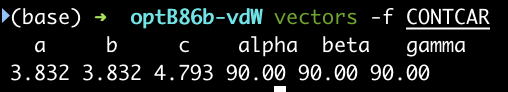

In [1]:
from pymatgen.core.surface import SlabGenerator, generate_all_slabs, Structure, Lattice
import pymatgen.symmetry.analyzer as pmgsyman

In [2]:
optB86bvdW_relaxed = Structure.from_file("VASP_Files/optB86b-vdW/CONTCAR")
optB86bvdW_relaxed.add_oxidation_state_by_guess()

Relaxed (predicted) structural parameters:

In [3]:
optB86bvdW_relaxed

Structure Summary
Lattice
    abc : 3.8321500113692926 3.8321500113692926 4.792723931047374
 angles : 90.0 90.0 90.0
 volume : 70.3829420145544
      A : 3.8321500113692926 -0.0 0.0
      B : -1e-16 3.8321500113692926 0.0
      C : -0.0 0.0 4.792723931047374
PeriodicSite: Sn2+ (2.8741, 2.8741, 1.1614) [0.7500, 0.7500, 0.2423]
PeriodicSite: Sn2+ (0.9580, 0.9580, 3.6313) [0.2500, 0.2500, 0.7577]
PeriodicSite: O2- (0.9580, 2.8741, 0.0000) [0.2500, 0.7500, 0.0000]
PeriodicSite: O2- (2.8741, 0.9580, 0.0000) [0.7500, 0.2500, 0.0000]

In [4]:
spganalyse_opt = pmgsyman.SpacegroupAnalyzer(optB86bvdW_relaxed)

In [13]:
print("Point group symbol, space group symbol, space group number:")
print(spganalyse_opt.get_point_group_symbol(), '\t\t\t', spganalyse_opt.get_space_group_symbol(),
      '\t\t\t', spganalyse_opt.get_space_group_number())

Point group symbol, space group symbol, space group number:
4/mmm 			 P4/nmm 			 129


Maintains the same initial symmetry (P4/nmm), and does not relax to a different structure, as expected.

### Experimental:

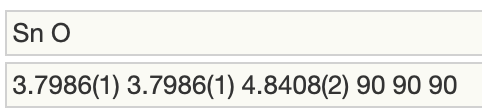    
(ICSD 11516)

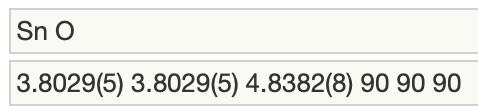   
(ICSD 16481)

In [15]:
print("Taking a,b = 3.80 Angstrom, c = 4.84 Angstrom as the experimental lattice parameters")
print("with a,b = 3.832, c = 4.793 as the calculated parameters, the relative error in")
print(f"a,b is {0.032/3.8:.2%}, and {(4.84-4.793)/4.84:.2%} for c")

Taking a,b = 3.80 Angstrom, c = 4.84 Angstrom as the experimental lattice parameters
with a,b = 3.832, c = 4.793 as the calculated parameters, the relative error in
a,b is 0.84%, and 0.97% for c


Less than 1% error in predicted lattice parameters = good agreement with experiment.   
Also, note that the DFT calculations are athermal (i.e. at T = 0K), so a slight expansion along the _c_ direction would be expected (i.e. we would expect the predicted _c_ lattice parameter to be _smaller_ than the experimental value, as is the case.

## Slab Calculations

In [39]:
optB86bvdW_slabs_vacthic_10 = generate_all_slabs(optB86bvdW_relaxed, max_index=2, 
                                      min_slab_size=10, min_vacuum_size=10, lll_reduce=True)

In [40]:
dipole_free_slabs_vacthic_10 = []
for slab in optB86bvdW_slabs_vacthic_10:
    if not slab.is_polar():
        dipole_free_slabs_vacthic_10.append(slab)

In [136]:
#from pymatgen.entries.computed_entries import ComputedStructureEntry
from pymatgen.io.vasp.outputs import Vasprun
bulk_sno_vasprun = Vasprun("./VASP_Files/optB86b-vdW/bulk_rerun/vasprun.xml")
bulk_sno_entry = bulk_sno_vasprun.get_computed_entry()

In [137]:
import scipy.constants as scpc
import os
from pymatgen.io.vasp.outputs import Vasprun
from pymatgen.analysis.surface_analysis import SlabEntry
dipolefree_slabs_vaspruns = {}
for root, dirs, files in os.walk("./VASP_Files/optB86b-vdW/"):
    for name in files:
        if "_Slab" in root[-10:]:
            if "vasprun" in name:
                #print(os.path.join(root, name))
                dipolefree_slabs_vaspruns[root[-8:]] = {'vasprun': Vasprun(os.path.join(root, name)), 
                                                         'thickness': 10,'vacuum': 10,
                                                        'miller index': (int(root[-8]),int(root[-7]),int(root[-6]))}

for k,v in dipolefree_slabs_vaspruns.items():
    v['final_energy'] = v['vasprun'].final_energy
    v['SlabEntry'] = SlabEntry.from_computed_structure_entry(v['vasprun'].get_computed_entry(),
                                                             v['miller index'])
    v['SurfaceEnergyJm2'] = v['SlabEntry'].surface_energy(bulk_sno_entry)*scpc.electron_volt*10**20 # Convert eV/A^2 to J/m^2

In [138]:
for k,v in dipolefree_slabs_vaspruns.items():
    print(f"Miller Index: {v['miller index']} \t Surface Energy:   {v['SurfaceEnergyJm2']:.2f} J/m^2")

Miller Index: (2, 1, 2) 	 Surface Energy:   0.64 J/m^2
Miller Index: (1, 0, 1) 	 Surface Energy:   0.57 J/m^2
Miller Index: (1, 0, 0) 	 Surface Energy:   0.61 J/m^2
Miller Index: (1, 1, 1) 	 Surface Energy:   0.71 J/m^2
Miller Index: (0, 0, 1) 	 Surface Energy:   0.25 J/m^2
Miller Index: (2, 2, 1) 	 Surface Energy:   1.30 J/m^2
Miller Index: (2, 0, 1) 	 Surface Energy:   0.61 J/m^2
Miller Index: (1, 1, 2) 	 Surface Energy:   0.61 J/m^2
Miller Index: (2, 1, 0) 	 Surface Energy:   0.77 J/m^2
Miller Index: (2, 1, 1) 	 Surface Energy:   1.14 J/m^2
Miller Index: (1, 0, 2) 	 Surface Energy:   0.48 J/m^2


In [139]:
from pymatgen.analysis.wulff import WulffShape

In [140]:
sno_miller_indices = []
sno_surface_energies_jm2 = []
for k,v in dipolefree_slabs_vaspruns.items():
    if v['miller index'] in [(0,0,1)]:
        c_energy = v['SurfaceEnergyJm2'] # Bug in the code, can't use 001 miller index, need to 
        # specify as 0.0000000000001, 0, 1
    else:
        sno_miller_indices.append(v['miller index']) # Might need to reformat this
        sno_surface_energies_jm2.append(v['SurfaceEnergyJm2'])
sno_miller_indices.append((0.00000000001, 0, 1)) # Bug in the code, can't use 001 miller index, 
# need to specify as 0.0000000000001, 0, 1
sno_surface_energies_jm2.append(c_energy)
wulff_sno = WulffShape(optB86bvdW_relaxed.lattice,sno_miller_indices,sno_surface_energies_jm2)

In [141]:
print(f"Miller Index:  Normalised Surface Area in Wulff Shape: (i.e. Wulff surface area fraction)")
for k,v in wulff_sno.miller_area_dict.items():
    print(k, f"\t\t\t {v/wulff_sno.surface_area:.3f}")
print("\n'(1e-11, 0, 1)' = (0, 0, 1) btw")

Miller Index:  Normalised Surface Area in Wulff Shape: (i.e. Wulff surface area fraction)
(2, 1, 2) 			 0.160
(1, 0, 1) 			 0.111
(1, 0, 0) 			 0.205
(1, 1, 1) 			 0.002
(2, 2, 1) 			 0.000
(2, 0, 1) 			 0.032
(1, 1, 2) 			 0.001
(2, 1, 0) 			 0.006
(2, 1, 1) 			 0.000
(1, 0, 2) 			 0.047
(1e-11, 0, 1) 			 0.437

'(1e-11, 0, 1)' = (0, 0, 1) btw


In [66]:
print("Shape factor: %.3f, Anisotropy: \
%.3f, Weighted surface energy: %.3f J/m^2" %(wulff_sno.shape_factor, 
                                       wulff_sno.anisotropy,
                                       wulff_sno.weighted_surface_energy))
# Typically in the literature when discussing surface anisotropy, we would only look at the ratios of 
# 2 surface energies when talking about anisotropy. eg. the ratio of a generic fcc (111) to (100) 
# surface energy should be less than 1 as the (111) facet is the closest packed surface of an fcc 
# structure and should have the lowest surface energy. However this method of determining surface 
# anisotropy does not allow us to determine an overall anisotropy of a material, ie. how different 
# are all the surface energies for a material. As such, we used the Coefficient of Variation from the 
# weighted surface energy. For reference, an ideal sphere Wulff shape (eg. completely isotropic) has 
# a anisotropy of 0.
# shape_factor:
# An alternative to anisotropy. This is useful for determining the critical nucleus size. A 
# large shape factor indicates great anisotropy. See Ballufi, R. W., Allen, S. M. & Carter, 
# W. C. Kinetics of Materials. (John Wiley & Sons, 2005), p.461

Shape factor: 5.853, Anisotropy: 0.391, Weighted surface energy: 0.450 J/m^2


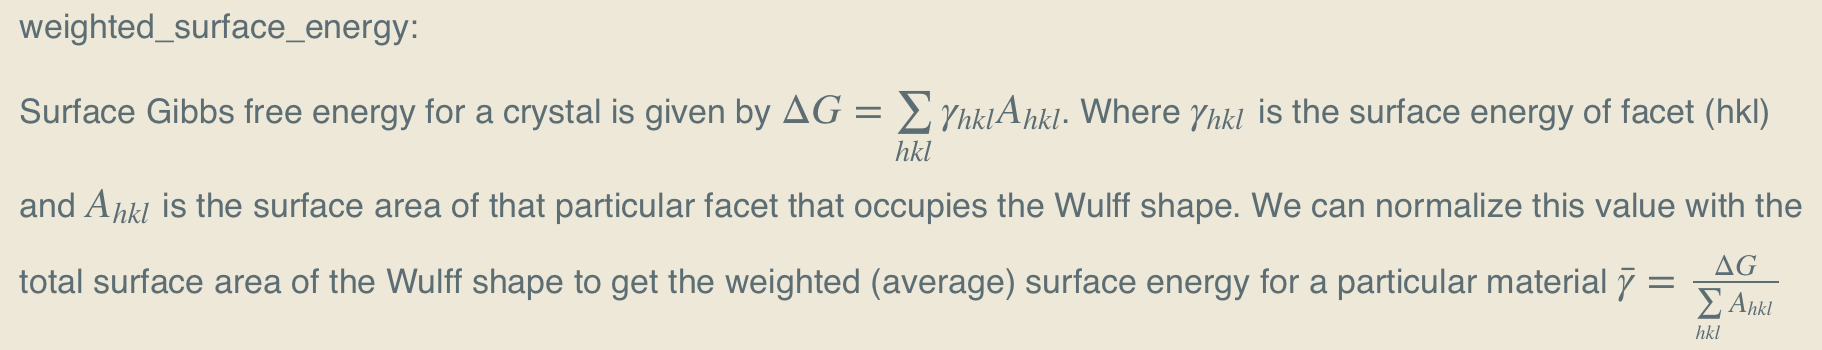

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

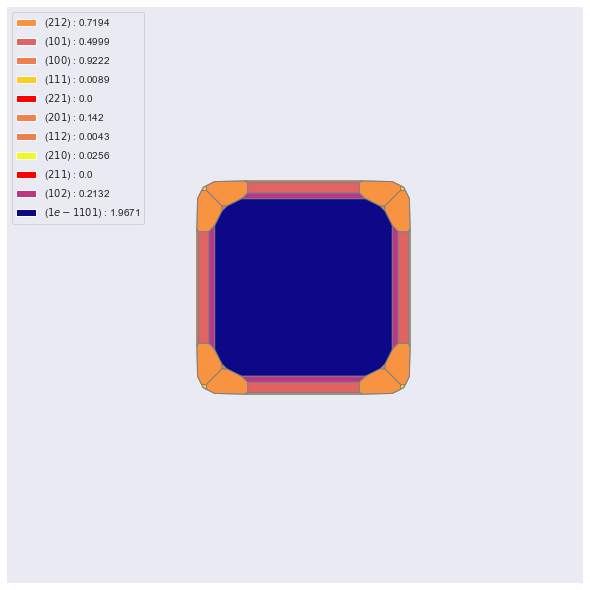

In [151]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
wulff_plot = wulff_sno.get_plot(color_set='plasma', grid_off=False, show_area = True)

See images and videos for different viewpoints on Wulff Shape. Looks similar to the platelets in the Ethylene Glycol solvent. Suggests that solvents (like $H_2O$ and EtOH) have strong kinetic effects, further stabilising the 001 face relative to other surfaces (-> making thinnner platelets).

**In particular,** if you look at the CrystalMaker `Surface_Relaxation` file, which shows the initial and final (relaxed) structures for the important crystal facets ((001), (100), (101) and (212) - see Labelled Wulff Shape). Notably, even after surface relaxations (very small for (001) as expected, but some small reconstructions for the others), only the (001) surface has exposed Tin atoms (in all other cases, Oxygen is more prominent at the surface). Hence more amenable to adsorption via Oxygen in $H_2O$, EtOH etc. Particularly for $H_2O$ -> close-packed adsorption on (001) surface, strong kinetic stabilisation, wide squares?

In [67]:
import macrodensity as md
import io
import sys
import matplotlib.pyplot as plt; import matplotlib as mpl

Average of the average =  2.3021584638627245e-13


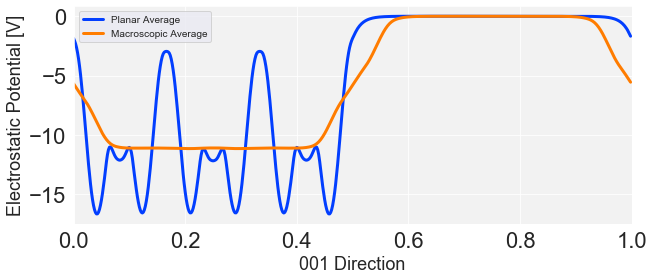

In [82]:
%matplotlib inline
input_file = 'VASP_Files/optB86b-vdW/001_Slab/LOCPOT'
lattice_vector = (4.8); output_file = 'whofuckingcares.dat'
# create a text trap and redirect stdout (I've seen Macrodensity's big BOOM enough fucking times...)
text_trap = io.StringIO(); old_stdout = sys.stdout; sys.stdout = text_trap
vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density(input_file) # execute our now mute functions
vector_a,vector_b,vector_c,av,bv,cv = md.matrix_2_abc(Lattice) 
resolution_x = vector_a/NGX; resolution_y = vector_b/NGY; resolution_z = vector_c/NGZ
grid_pot, electrons = md.density_2_grid(vasp_pot,NGX,NGY,NGZ)
sys.stdout = old_stdout # now restore stdout function
planar001 = md.planar_average(grid_pot,NGX,NGY,NGZ); macro  = md.macroscopic_average(planar001,lattice_vector,resolution_z)
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10,4)); textsize = 22
mpl.rcParams['xtick.labelsize'] = textsize; mpl.rcParams['ytick.labelsize'] = textsize; plt.rcParams['legend.title_fontsize'] = 22
ax.plot(np.arange(0,1,1.0/len(planar001)), planar001-planar001[400],label="Planar Average",lw=3)
ax.plot(np.arange(0,1,1.0/len(planar001)), macro-macro[400],label="Macroscopic Average",lw=3); 
plt.setp(ax, xlim=(0,1), facecolor=((0.95,0.95,0.95))); ax.grid(True); ax.legend()
ax.set_ylabel('Electrostatic Potential [V]', fontsize = 18)
ax.set_xlabel('001 Direction', fontsize = 18)
plt.show()
#print(f"Using plateaus in the centre of each slab: Offset (Bi relative to Sb) = {macro[91]-macro[270]:.4f} V")

Average of the average =  6.158037043254202e-15


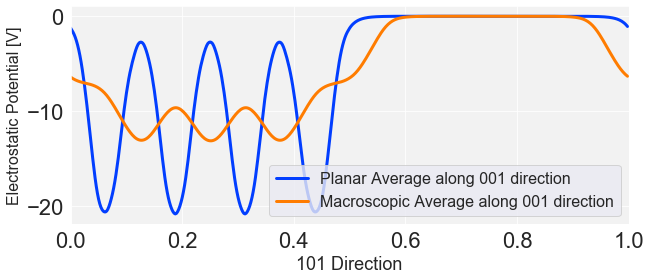

In [102]:
%matplotlib inline
input_file = 'VASP_Files/optB86b-vdW/101_Slab/LOCPOT'
lattice_vector = (4.8); output_file = 'whofuckingcares.dat'
# create a text trap and redirect stdout (I've seen Macrodensity's big BOOM enough fucking times...)
text_trap = io.StringIO(); old_stdout = sys.stdout; sys.stdout = text_trap
vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density(input_file) # execute our now mute functions
vector_a,vector_b,vector_c,av,bv,cv = md.matrix_2_abc(Lattice) 
resolution_x = vector_a/NGX; resolution_y = vector_b/NGY; resolution_z = vector_c/NGZ
grid_pot, electrons = md.density_2_grid(vasp_pot,NGX,NGY,NGZ)
sys.stdout = old_stdout # now restore stdout function
planar001 = md.planar_average(grid_pot,NGX,NGY,NGZ); macro  = md.macroscopic_average(planar001,lattice_vector,resolution_z)
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10,4)); textsize = 22
mpl.rcParams['xtick.labelsize'] = textsize; mpl.rcParams['ytick.labelsize'] = textsize; plt.rcParams['legend.title_fontsize'] = 22
ax.plot(np.arange(0,1,1.0/len(planar001)), planar001-planar001[400],label="Planar Average along 001 direction",lw=3)
ax.plot(np.arange(0,1,1.0/len(planar001)), macro-macro[400],label="Macroscopic Average along 001 direction",lw=3); 
plt.setp(ax, xlim=(0,1), facecolor=((0.95,0.95,0.95))); ax.grid(True); ax.legend(fontsize = 16)
ax.set_ylabel('Electrostatic Potential [V]', fontsize = 16)
ax.set_xlabel('101 Direction', fontsize = 18)
plt.show()
#print(f"Using plateaus in the centre of each slab: Offset (Bi relative to Sb) = {macro[91]-macro[270]:.4f} V")

Average of the average =  6.158037043254202e-15


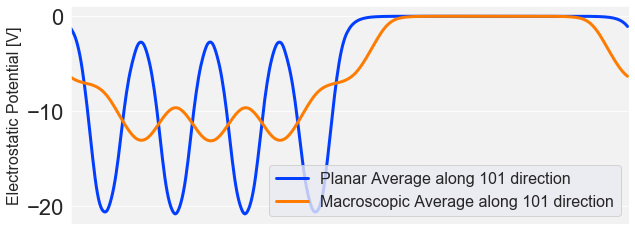

In [101]:
%matplotlib inline
input_file = 'VASP_Files/optB86b-vdW/101_Slab/LOCPOT'
lattice_vector = (4.8); output_file = 'whofuckingcares.dat'
# create a text trap and redirect stdout (I've seen Macrodensity's big BOOM enough fucking times...)
text_trap = io.StringIO(); old_stdout = sys.stdout; sys.stdout = text_trap
vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density(input_file) # execute our now mute functions
vector_a,vector_b,vector_c,av,bv,cv = md.matrix_2_abc(Lattice) 
resolution_x = vector_a/NGX; resolution_y = vector_b/NGY; resolution_z = vector_c/NGZ
grid_pot, electrons = md.density_2_grid(vasp_pot,NGX,NGY,NGZ)
sys.stdout = old_stdout # now restore stdout function
planar001 = md.planar_average(grid_pot,NGX,NGY,NGZ); macro  = md.macroscopic_average(planar001,lattice_vector,resolution_z)
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10,4)); textsize = 22
mpl.rcParams['xtick.labelsize'] = textsize; mpl.rcParams['ytick.labelsize'] = textsize; plt.rcParams['legend.title_fontsize'] = 22
ax.plot(np.arange(0,1,1.0/len(planar001)), planar001-planar001[400],label="Planar Average along 101 direction",lw=3)
ax.plot(np.arange(0,1,1.0/len(planar001)), macro-macro[400],label="Macroscopic Average along 101 direction",lw=3); 
plt.setp(ax, xlim=(0,1), facecolor=((0.95,0.95,0.95))); ax.grid(True); ax.legend(fontsize = 16)
ax.set_ylabel('Electrostatic Potential [V]', fontsize = 16)
ax.set_xlabel('101 Direction', fontsize = 18)
ax.get_xaxis().set_visible(False)
plt.show()
#print(f"Using plateaus in the centre of each slab: Offset (Bi relative to Sb) = {macro[91]-macro[270]:.4f} V")

See Appendix: Local Potential Plots for other surfaces, if of interest.

#### Plot of Electrostatic Potential at Relaxed Surface Edge, for all terminations:

In [156]:
planar_data = {}; macro_data = {}
for root, dirs, files in os.walk("./VASP_Files/optB86b-vdW/"):
    for name in files:
        if "_Slab" in root[-10:]:
            if "LOCPOT" in name:
                if "221" in root:
                    continue
                input_file = os.path.join(root, name)
                lattice_vector = (4.8); output_file = 'whofuckingcares.dat'
                # create a text trap and redirect stdout (I've seen Macrodensity's big BOOM enough fucking times...)
                text_trap = io.StringIO(); old_stdout = sys.stdout; sys.stdout = text_trap
                vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density(input_file) # execute our now mute functions
                vector_a,vector_b,vector_c,av,bv,cv = md.matrix_2_abc(Lattice) 
                resolution_x = vector_a/NGX; resolution_y = vector_b/NGY; resolution_z = vector_c/NGZ
                grid_pot, electrons = md.density_2_grid(vasp_pot,NGX,NGY,NGZ)
                sys.stdout = old_stdout # now restore stdout function
                planar_data[root[-8:]] = md.planar_average(grid_pot,NGX,NGY,NGZ) 
                macro_data[root[-8:]]  = md.macroscopic_average(planar_data[root[-8:]],lattice_vector,resolution_z)

Average of the average =  3.684295666904223e-15
Average of the average =  6.158037043254202e-15
Average of the average =  -1.1419436824715896e-14
Average of the average =  5.921189464667502e-14
Average of the average =  2.3021584638627245e-13
Average of the average =  -2.590435802371108e-13
Average of the average =  -1.597029387041749e-14
Average of the average =  1.5370924487871556e-14
Average of the average =  1.2823875294998287e-13
Average of the average =  -1.8947806286936005e-15


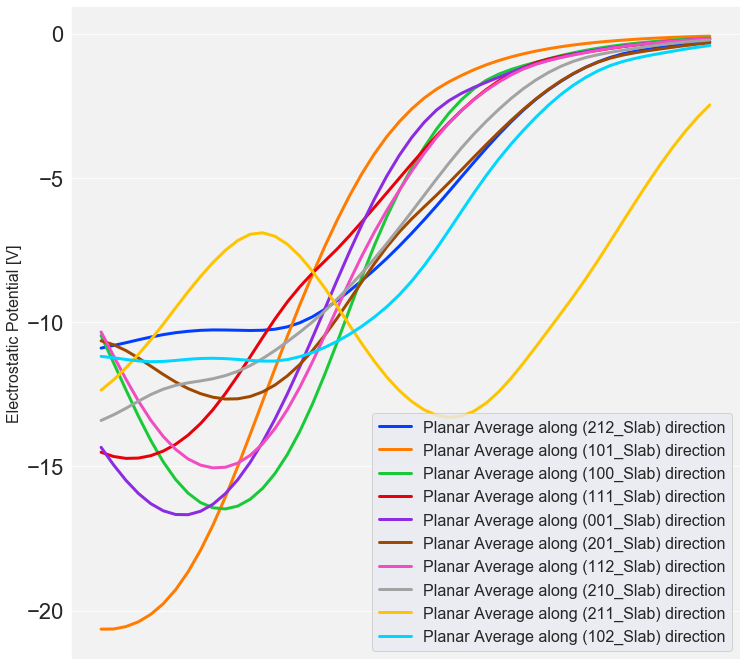

In [157]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(12,12)); textsize = 22
mpl.rcParams['xtick.labelsize'] = textsize; mpl.rcParams['ytick.labelsize'] = textsize; plt.rcParams['legend.title_fontsize'] = 22
for i, k in enumerate(planar_data):
    half = int(len(planar_data[k])/2)
    ax.plot((planar_data[k]-planar_data[k][350])[half-30:half+20],label=f"Planar Average along ({k}) direction",lw=3)
    ax.set_ylabel('Electrostatic Potential [V]', fontsize = 16)
    ax.get_xaxis().set_visible(False)
    ax.grid(True); 
    ax.legend(fontsize = 16)
plt.setp(ax, facecolor=((0.95,0.95,0.95))); 
plt.show()
#print(f"Using plateaus in the centre of each slab: Offset (Bi relative to Sb) = {macro[91]-macro[270]:.4f} V")

# Appendix

## Electrostatic Potential Plots

In [88]:
planar_data = {}; macro_data = {}
for root, dirs, files in os.walk("./VASP_Files/optB86b-vdW/"):
    for name in files:
        if "_Slab" in root[-10:]:
            if "LOCPOT" in name:
                input_file = os.path.join(root, name)
                lattice_vector = (4.8); output_file = 'whofuckingcares.dat'
                # create a text trap and redirect stdout (I've seen Macrodensity's big BOOM enough fucking times...)
                text_trap = io.StringIO(); old_stdout = sys.stdout; sys.stdout = text_trap
                vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density(input_file) # execute our now mute functions
                vector_a,vector_b,vector_c,av,bv,cv = md.matrix_2_abc(Lattice) 
                resolution_x = vector_a/NGX; resolution_y = vector_b/NGY; resolution_z = vector_c/NGZ
                grid_pot, electrons = md.density_2_grid(vasp_pot,NGX,NGY,NGZ)
                sys.stdout = old_stdout # now restore stdout function
                planar_data[root[-8:]] = md.planar_average(grid_pot,NGX,NGY,NGZ) 
                macro_data[root[-8:]]  = md.macroscopic_average(planar_data[root[-8:]],lattice_vector,resolution_z)

Average of the average =  3.684295666904223e-15
Average of the average =  6.158037043254202e-15
Average of the average =  -1.1419436824715896e-14
Average of the average =  5.921189464667502e-14
Average of the average =  2.3021584638627245e-13
Average of the average =  -1.001526903738046e-14
Average of the average =  -2.590435802371108e-13
Average of the average =  -1.597029387041749e-14
Average of the average =  1.5370924487871556e-14
Average of the average =  -1.8947806286936005e-15


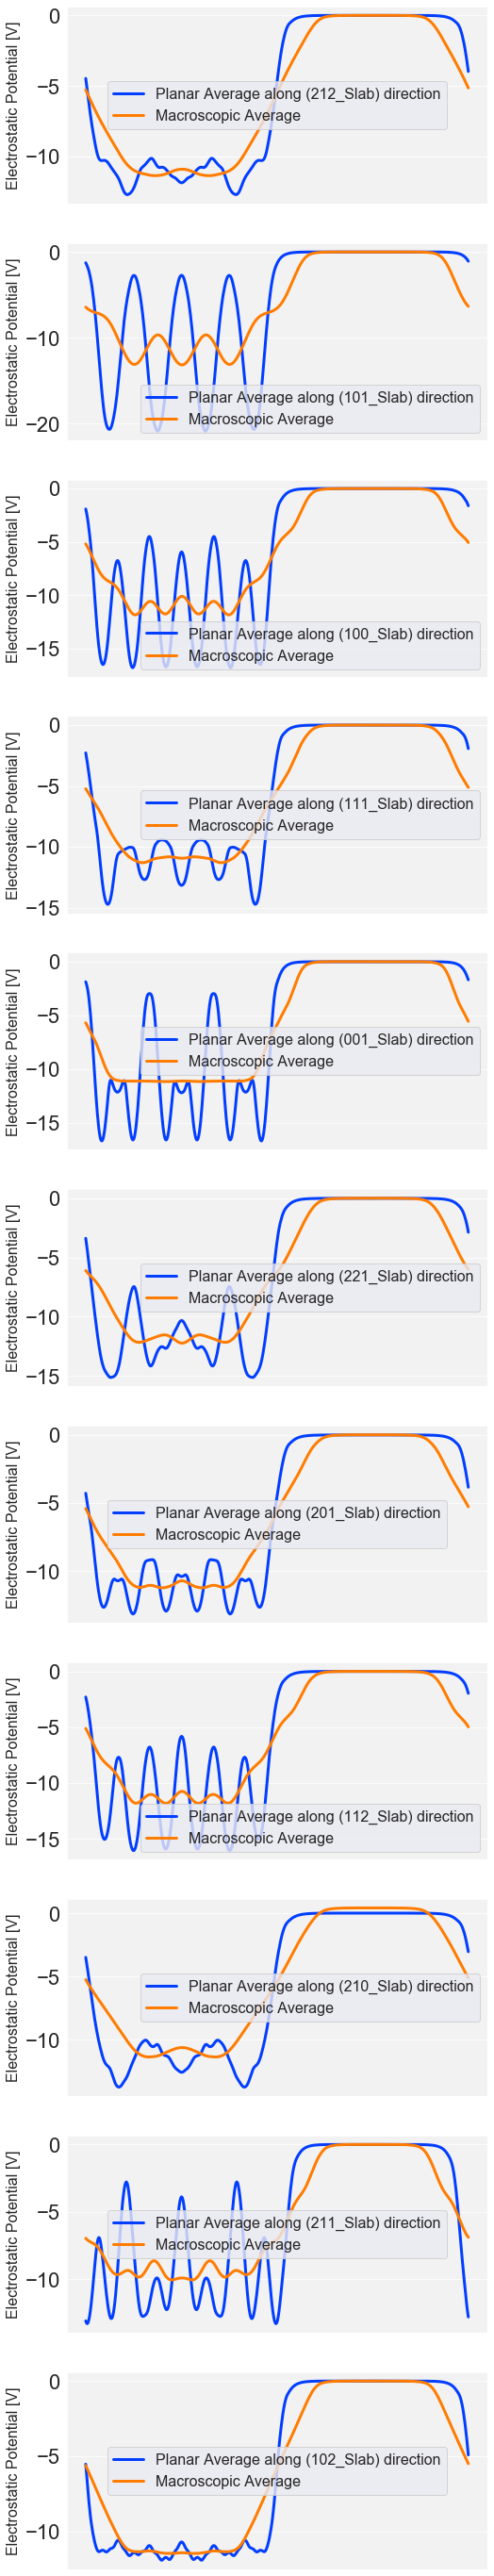

In [155]:
%matplotlib inline

fig, ax = plt.subplots(11, 1, figsize=(8,50)); textsize = 22
mpl.rcParams['xtick.labelsize'] = textsize; mpl.rcParams['ytick.labelsize'] = textsize; plt.rcParams['legend.title_fontsize'] = 22
for i, k in enumerate(planar_data):
    ax[i].plot(planar_data[k]-planar_data[k][350],label=f"Planar Average along ({k}) direction",lw=3)
for i, k in enumerate(macro_data):
    ax[i].plot(macro_data[k]-macro_data[k][350],label="Macroscopic Average",lw=3)
    ax[i].set_ylabel('Electrostatic Potential [V]', fontsize = 16)
    ax[i].get_xaxis().set_visible(False)
    ax[i].grid(True); ax[i].legend(fontsize = 16)
plt.setp(ax, facecolor=((0.95,0.95,0.95))); 
plt.show()
#print(f"Using plateaus in the centre of each slab: Offset (Bi relative to Sb) = {macro[91]-macro[270]:.4f} V")

## Supercell Slab Surface Areas

In [164]:
for i in dipole_free_slabs_vacthic_10:
    print(i.miller_index, f"\t -\t Surface Area of Slab: {i.surface_area:.3f} Angstrom^2")

(1, 1, 1) 	 -	 Surface Area of Slab: 29.838 Angstrom^2
(2, 2, 1) 	 -	 Surface Area of Slab: 53.984 Angstrom^2
(2, 1, 2) 	 -	 Surface Area of Slab: 50.490 Angstrom^2
(2, 1, 2) 	 -	 Surface Area of Slab: 50.490 Angstrom^2
(2, 1, 1) 	 -	 Surface Area of Slab: 43.615 Angstrom^2
(2, 1, 0) 	 -	 Surface Area of Slab: 41.069 Angstrom^2
(1, 0, 1) 	 -	 Surface Area of Slab: 23.516 Angstrom^2
(2, 0, 1) 	 -	 Surface Area of Slab: 39.560 Angstrom^2
(1, 0, 0) 	 -	 Surface Area of Slab: 18.366 Angstrom^2
(1, 1, 2) 	 -	 Surface Area of Slab: 39.208 Angstrom^2
(1, 0, 2) 	 -	 Surface Area of Slab: 34.641 Angstrom^2
(1, 0, 2) 	 -	 Surface Area of Slab: 34.641 Angstrom^2
(0, 0, 1) 	 -	 Surface Area of Slab: 14.685 Angstrom^2


## Supercell-size (Slab and Vacuum) Convergence Testing

### Convergence Testing (wrt Slab and Vacuum thicknesses) for (001)

Note that convergence within 0.02 J/m^2 is considered sufficiently accurate (see https://www.nature.com/articles/sdata201680)

In [26]:
import os
structure = optB86bvdW_relaxed
# These are distances in Angstroms
dist = [4,7,10,15,20,25,30,35,40,45,50,55,60]
# We iterate through the distances twice, once for vac, once for slab
for vac in dist:
    for thickness in dist:
        slabgen = SlabGenerator(structure, miller_index=(0,0,1), 
                                min_slab_size=thickness, min_vacuum_size =vac, lll_reduce=True)
        slabs = slabgen.get_slabs()
        slab = slabs[1] # <-- put a number in here! 
        #print(slab.miller_index) # just to check!
        if not os.path.exists('VASP_Files/optB86b-vdW/001_Slabs/slab_{0}_{1}/'.format(thickness,vac)):
            os.makedirs('VASP_Files/optB86b-vdW/001_Slabs/slab_{0}_{1}/'.format(thickness,vac))
        slab.to(fmt='poscar', filename='VASP_Files/optB86b-vdW/001_Slabs/slab_{0}_{1}/POSCAR'.format(thickness,vac))
        optB86bvdW_vasp_files(optB86bvdW_relaxed, input_dir='VASP_Files/optB86b-vdW/001_Slabs/slab_{0}_{1}'.format(thickness,vac))

In [43]:
#from pymatgen.entries.computed_entries import ComputedStructureEntry
from pymatgen.io.vasp.outputs import Vasprun
bulk_sno_vasprun = Vasprun("./VASP_Files/optB86b-vdW/bulk_rerun/vasprun.xml")
bulk_sno_entry = bulk_sno_vasprun.get_computed_entry()

In [17]:
import scipy.constants as scpc

In [19]:
import os
from pymatgen.io.vasp.outputs import Vasprun
from pymatgen.analysis.surface_analysis import SlabEntry
zerozeroone_slabs_vaspruns = {}
for root, dirs, files in os.walk("./VASP_Files/optB86b-vdW/001_Slabs/"):
    for name in files:
        if "vasprun" in name:
            #print(os.path.join(root, name))
            zerozeroone_slabs_vaspruns[name] = {'vasprun': Vasprun(os.path.join(root, name)), 'thickness': name[5:7],'vacuum': name[8:10]}
for k,v in zerozeroone_slabs_vaspruns.items():
    v['final_energy'] = v['vasprun'].final_energy
    v['SlabEntry'] = SlabEntry.from_computed_structure_entry(v['vasprun'].get_computed_entry(),(0,0,1))
    v['SurfaceEnergyJm2'] = v['SlabEntry'].surface_energy(bulk_sno_entry)*scpc.electron_volt*10**20 # Convert eV/A^2 to J/m^2

In [20]:
zerozeroonevac10_thic = []; zerozeroonevac10_energy = []
for k,v in zerozeroone_slabs_vaspruns.items():
    if v['vacuum'] == '10':
        zerozeroonevac10_thic.append(float(v['thickness']))
        zerozeroonevac10_energy.append(v['SurfaceEnergyJm2'])
        zerozeroonevac10 = sorted(zip(zerozeroonevac10_thic, zerozeroonevac10_energy), key = lambda t: t[0])

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_palette(sns.color_palette('bright'))
sns.set_style('darkgrid')

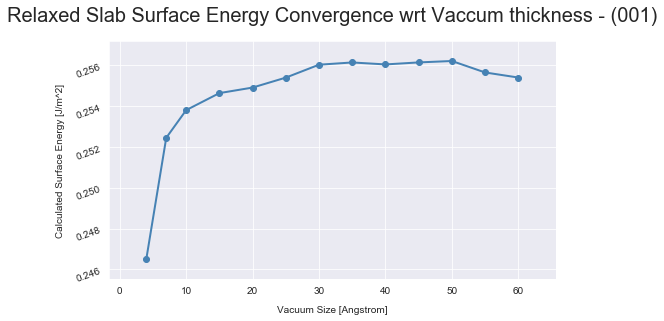

In [31]:
f,ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(*zip(*zerozeroonevac10), marker="o", linewidth=2, linestyle='-', color = 'steelblue')
ax.grid(True)
ax.set_xlabel("Vacuum Size [Angstrom]", labelpad=10)
ax.set_ylabel("Calculated Surface Energy [J/m^2]", labelpad=10)
ax.set_title("Relaxed Slab Surface Energy Convergence wrt Vaccum thickness - (001)",
              fontsize=20, pad=20)  # pad is offset of title from plot
# Adjusting the in-plot margins (i.e. the gap between the final x value and the x limit of the graph)
ax.margins(0.1)
ax.ticklabel_format(useOffset=False)
plt.setp(ax.get_yticklabels(), rotation=20)
f.subplots_adjust(bottom=0.3, top=0.85)  # Adjusting specific margins

Ok cool, 10 Angstrom vac, 10 Angstrom slab seems good enough for 001, but other directions might need more (because more broken/dangling bonds)

### (111) Slab Convergence Test

In [23]:
import os
structure = optB86bvdW_relaxed
# These are distances in Angstroms
dist = [4,7,10,15,20,25,30]
# We iterate through the distances twice, once for vac, once for slab
for vac in dist:
    for thickness in dist:
        slabgen = SlabGenerator(structure, miller_index=(1,1,1), 
                                min_slab_size=thickness, min_vacuum_size=vac, lll_reduce=True)
        slabs = slabgen.get_slabs()
        slab = slabs[1] # <-- put a number in here! 
        #print(slab.miller_index) # just to check!
        if not os.path.exists('VASP_Files/optB86b-vdW/111_Slabs/slab_{0}_{1}/'.format(thickness,vac)):
            os.makedirs('VASP_Files/optB86b-vdW/111_Slabs/slab_{0}_{1}/'.format(thickness,vac))
        slab.to(fmt='poscar', filename='VASP_Files/optB86b-vdW/111_Slabs/slab_{0}_{1}/POSCAR'.format(thickness,vac))
        optB86bvdW_vasp_files(optB86bvdW_relaxed, input_dir='VASP_Files/optB86b-vdW/111_Slabs/slab_{0}_{1}'.format(thickness,vac))

In [44]:
# import scipy.constants as scpc
import os
from pymatgen.io.vasp.outputs import Vasprun
from pymatgen.analysis.surface_analysis import SlabEntry
oneoneone_slabs_vaspruns = {}
for root, dirs, files in os.walk("./VASP_Files/optB86b-vdW/111_Slabs/"):
    for name in files:
        if "vasprun" in name:
            #print(os.path.join(root, name))
            oneoneone_slabs_vaspruns[root[-10:]] = {'vasprun': Vasprun(os.path.join(root, name)), 'thickness': root[-5:-3],'vacuum': root[-2:]}
for k,v in oneoneone_slabs_vaspruns.items():
    v['final_energy'] = v['vasprun'].final_energy
    v['SlabEntry'] = SlabEntry.from_computed_structure_entry(v['vasprun'].get_computed_entry(),(1,1,1))
    v['SurfaceEnergyJm2'] = v['SlabEntry'].surface_energy(bulk_sno_entry)*scpc.electron_volt*10**20 # Convert eV/A^2 to J/m^2
   # v['TestSurfaceEnergy'] = ((v['final_energy']-(7*bulk_sno_entry.energy))/(2*14.68537370963767))*scpc.electron_volt*10**20 # Convert eV/A^2 to J/m^2

In [30]:
oneoneonethic10_vac = []; oneoneonethic10_energy = []
for k,v in oneoneone_slabs_vaspruns.items():
    if v['thickness'] == '10':
        oneoneonethic10_vac.append(float(v['vacuum']))
        oneoneonethic10_energy.append(v['SurfaceEnergyJm2'])
        oneoneonethic10 = sorted(zip(oneoneonethic10_vac, oneoneonethic10_energy), key = lambda t: t[0])

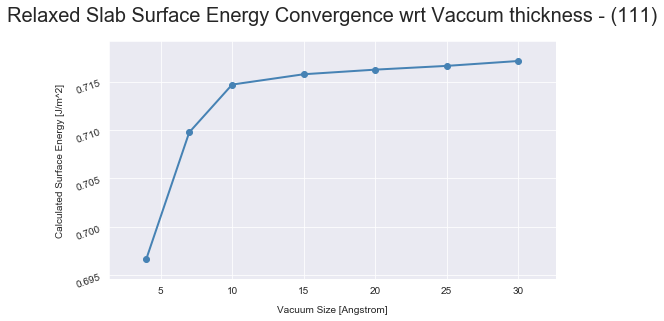

In [32]:
f,ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(*zip(*oneoneonethic10), marker="o", linewidth=2, linestyle='-', color = 'steelblue')
ax.grid(True)
ax.set_xlabel("Vacuum Size [Angstrom]", labelpad=10)
ax.set_ylabel("Calculated Surface Energy [J/m^2]", labelpad=10)
ax.set_title("Relaxed Slab Surface Energy Convergence wrt Vaccum thickness - (111)",
              fontsize=20, pad=20)  # pad is offset of title from plot
# Adjusting the in-plot margins (i.e. the gap between the final x value and the x limit of the graph)
ax.margins(0.1)
ax.ticklabel_format(useOffset=False)
plt.setp(ax.get_yticklabels(), rotation=20)
f.subplots_adjust(bottom=0.3, top=0.85)  # Adjusting specific margins

Converged at 10 Angstrom vacuum. Double check with 15 Angstrom thick slabs (so that vacuum convergence doesn't depend on slab thickness, which it shouldn't...), then just stick with 10 Angstrom vacuum and converge wrt slab size.

In [33]:
oneoneonethic15_vac = []; oneoneonethic15_energy = []
for k,v in oneoneone_slabs_vaspruns.items():
    if v['thickness'] == '15':
        oneoneonethic15_vac.append(float(v['vacuum']))
        oneoneonethic15_energy.append(v['SurfaceEnergyJm2'])
        oneoneonethic15 = sorted(zip(oneoneonethic15_vac, oneoneonethic15_energy), key = lambda t: t[0])

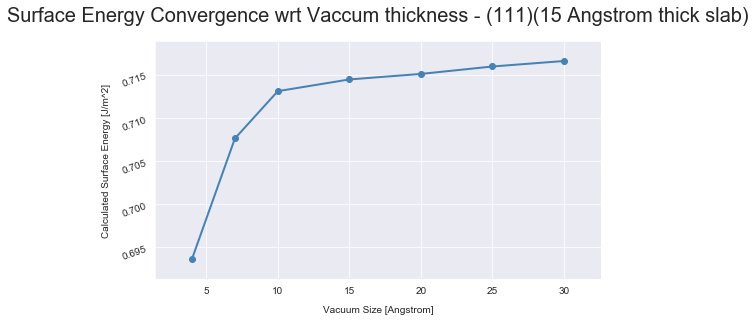

In [35]:
f,ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(*zip(*oneoneonethic15), marker="o", linewidth=2, linestyle='-', color = 'steelblue')
ax.grid(True)
ax.set_xlabel("Vacuum Size [Angstrom]", labelpad=10)
ax.set_ylabel("Calculated Surface Energy [J/m^2]", labelpad=10)
ax.set_title("Surface Energy Convergence wrt Vaccum thickness - (111)(15 Angstrom thick slab)",
              fontsize=20, pad=20)  # pad is offset of title from plot
# Adjusting the in-plot margins (i.e. the gap between the final x value and the x limit of the graph)
ax.margins(0.1)
ax.ticklabel_format(useOffset=False)
plt.setp(ax.get_yticklabels(), rotation=20)
f.subplots_adjust(bottom=0.3, top=0.85)  # Adjusting specific margins

Yep, still converged at 10 Angstrom vac. Let's run convergence test wrt slab thickness, at 10 Angstrom vacuums.

In [45]:
# import scipy.constants as scpc
import os
from pymatgen.io.vasp.outputs import Vasprun
from pymatgen.analysis.surface_analysis import SlabEntry
oneoneone_slabs_vaspruns = {}
for root, dirs, files in os.walk("./VASP_Files/optB86b-vdW/111_Slabs/"):
    for name in files:
        if "vasprun" in name:
            #print(os.path.join(root, name))
            oneoneone_slabs_vaspruns[root[-10:]] = {'vasprun': Vasprun(os.path.join(root, name)), 'thickness': root[-5:-3],'vacuum': root[-2:]}
for k,v in oneoneone_slabs_vaspruns.items():
    v['final_energy'] = v['vasprun'].final_energy
    v['SlabEntry'] = SlabEntry.from_computed_structure_entry(v['vasprun'].get_computed_entry(),(1,1,1))
    v['SurfaceEnergyJm2'] = v['SlabEntry'].surface_energy(bulk_sno_entry)*scpc.electron_volt*10**20 # Convert eV/A^2 to J/m^2

In [37]:
oneoneonevac10_thic = []; oneoneonevac10_energy = []
for k,v in oneoneone_slabs_vaspruns.items():
    if v['vacuum'] == '10':
        oneoneonevac10_thic.append(float(v['thickness']))
        oneoneonevac10_energy.append(v['SurfaceEnergyJm2'])
        oneoneonevac10 = sorted(zip(oneoneonevac10_thic, oneoneonevac10_energy), key = lambda t: t[0])

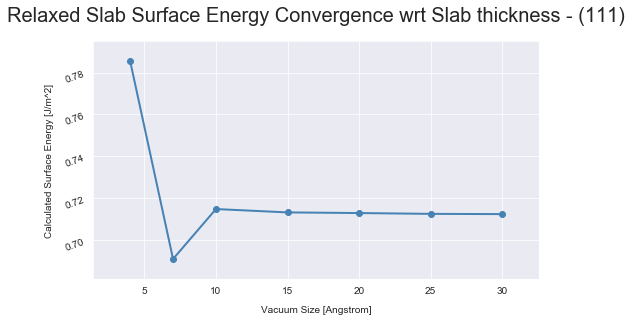

In [38]:
f,ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(*zip(*oneoneonevac10), marker="o", linewidth=2, linestyle='-', color = 'steelblue')
ax.grid(True)
ax.set_xlabel("Vacuum Size [Angstrom]", labelpad=10)
ax.set_ylabel("Calculated Surface Energy [J/m^2]", labelpad=10)
ax.set_title("Relaxed Slab Surface Energy Convergence wrt Slab thickness - (111)",
              fontsize=20, pad=20)  # pad is offset of title from plot
# Adjusting the in-plot margins (i.e. the gap between the final x value and the x limit of the graph)
ax.margins(0.1)
ax.ticklabel_format(useOffset=False)
plt.setp(ax.get_yticklabels(), rotation=20)
f.subplots_adjust(bottom=0.3, top=0.85)  # Adjusting specific margins

Ayo, yeah slab and vacuum thicknesses both converged at 10 Angstrom respectively.

## Structural Relaxation
(Functional, calculation parameters, results)

PBEsol: - `ENCUT = 850`, **_k_**-mesh = $7\times7\times5$

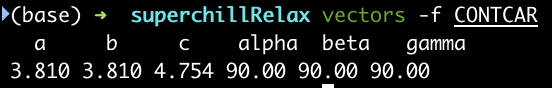

PBEsol + D3: - `ENCUT = 850`, **_k_**-mesh = $6\times6\times4$

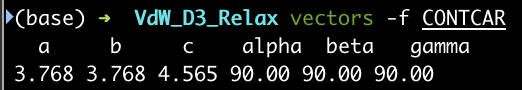

PBEsol + SOC + D3: - `ENCUT = 850`, **_k_**-mesh = $6\times6\times4$

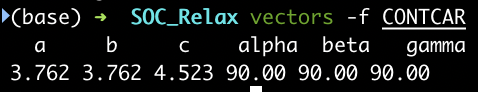

PBE + D3: - `ENCUT = 850`, **_k_**-mesh = $6\times6\times4$

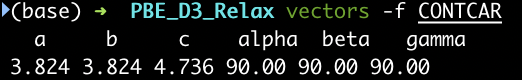

PBE + SOC + D3: - `ENCUT = 850`, **_k_**-mesh = $6\times6\times4$

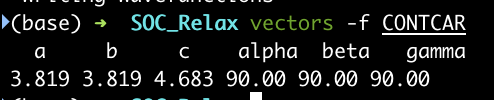

SCAN+rVV10: - `ENCUT = 850`, **_k_**-mesh = $6\times6\times4$ (Meta-GGA)   

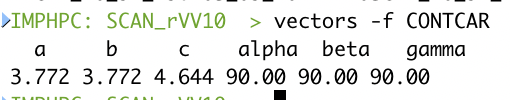

SOC not possible with SCAN_rVV10.

SCAN: - `ENCUT = 850`, **_k_**-mesh = $6\times6\times4$ (Meta-GGA)   

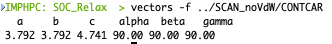

SCAN+SOC: - `ENCUT = 850`, **_k_**-mesh = $6\times6\times4$ (Meta-GGA)   

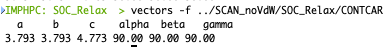

From Hoye's "Perovskite-Inspired..."
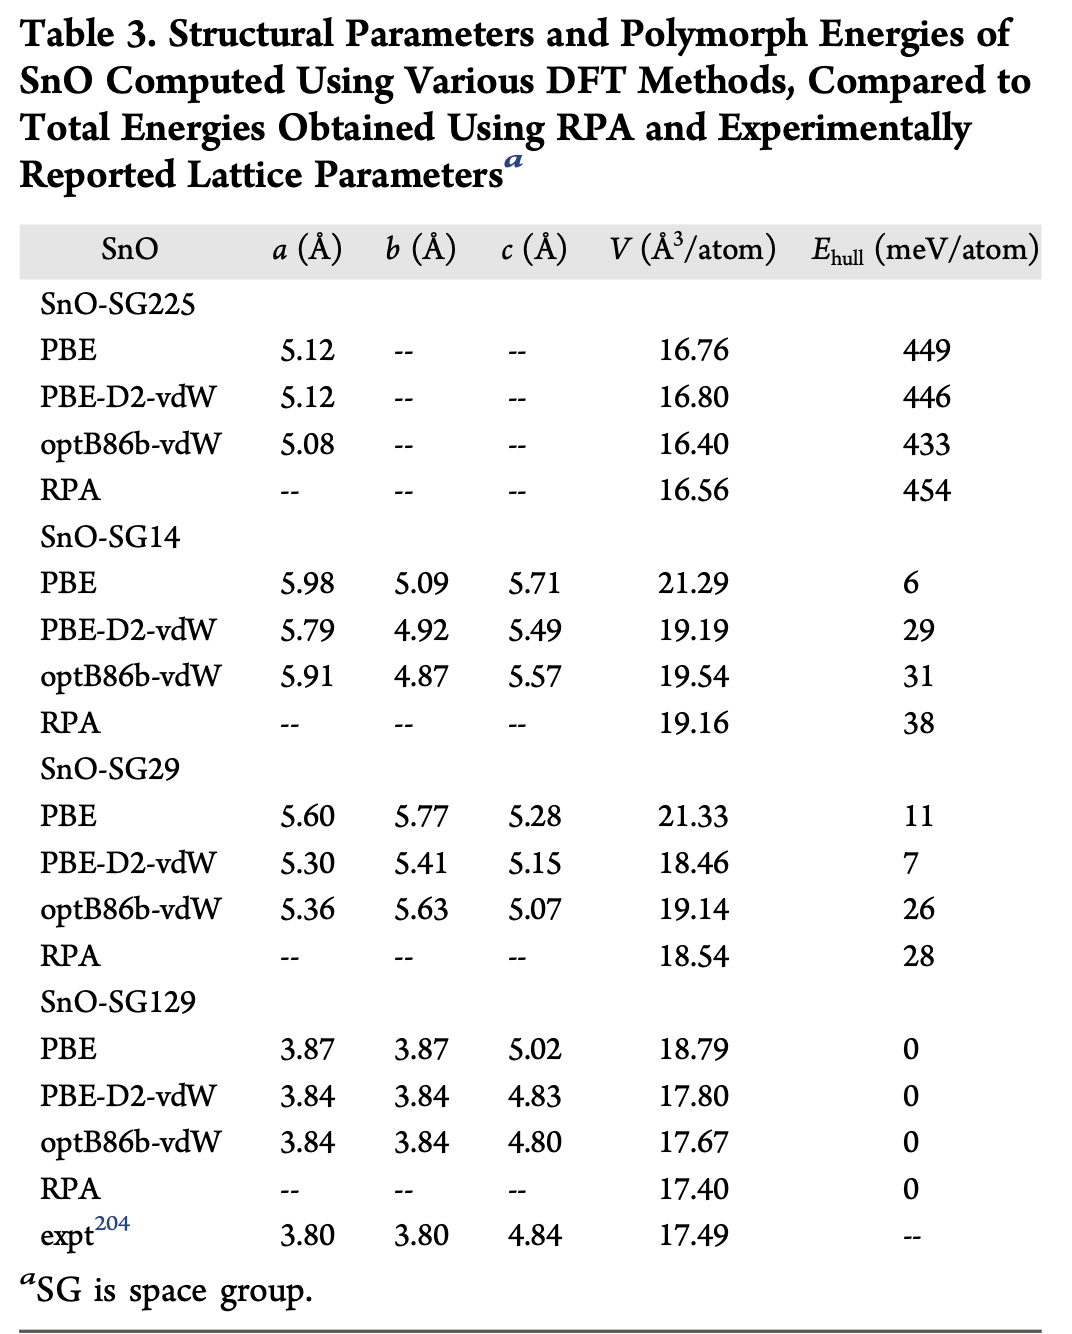

## Ground-State Energy Convergence Tests

`PSMAXN` warning encountered for `ENCUT = 900` and above.    
Well-converged (to within 1 meV/atom) at `ENCUT = 700` and **_k_**-mesh of $6\times6\times4$ for vanilla GGA.

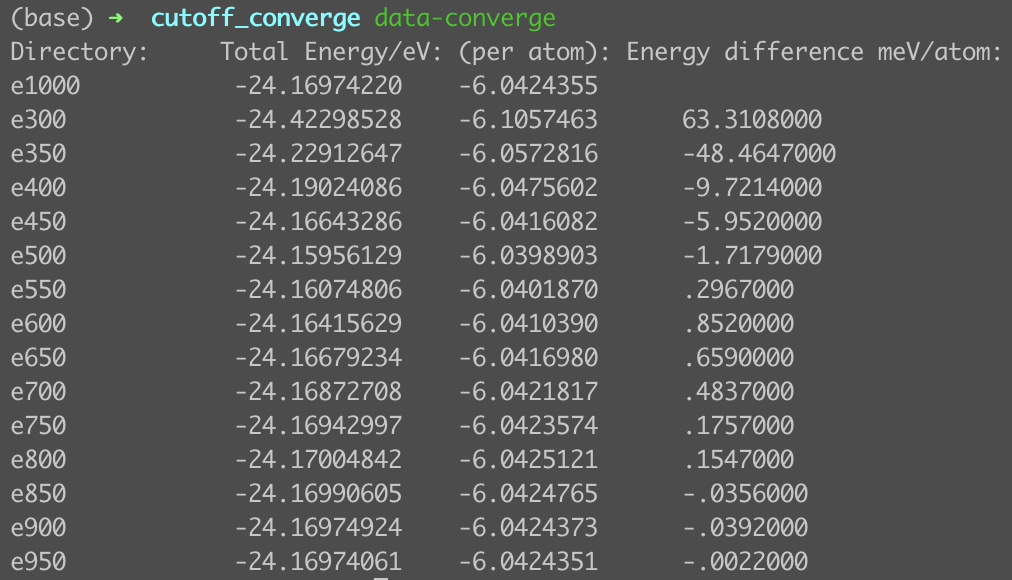

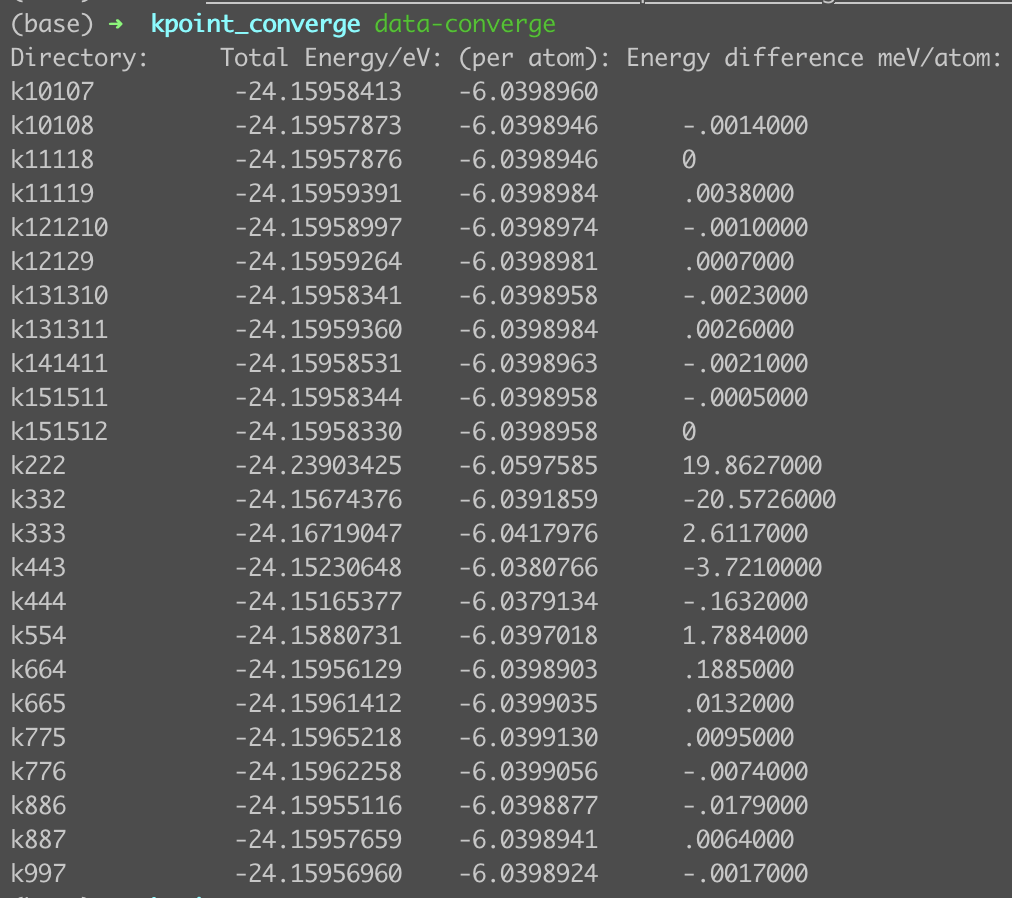